# Bubble Count and Volume (Area) Estimation

In this notebook I take an image of the underwater part of the proces and count the bubbles in each image.
We try to estimate the volume of entraped air and to make a size distribution of the bubbles. 


In [2]:
import cv2
import os, fnmatch
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

Import images names

In [105]:
dirAos = '../hoose jet/19-sep-18/AOS/FLM209/' #This set contains images of high flow (Q=1.98 l/min)
                                                # with a 4cm fallind distance

listOfFiles2 = os.listdir(dirAos)
pattern2 = "FLM209_p*.tif"

filesAOS=sorted(glob.glob(dirAos+pattern2))
filesAOS[0]

'../hoose jet/19-sep-18/AOS/FLM209/FLM209_p0497.tif'

We can see the image has some areas that are not interesting for the anaylsis so we will crop the images to the interest area. Which is only beneath the surface.

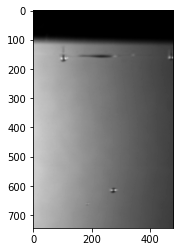

In [106]:
im = tiff.imread(filesAOS[0])
plt.imshow(im, cmap = 'gray', interpolation = 'bicubic')
plt.show()

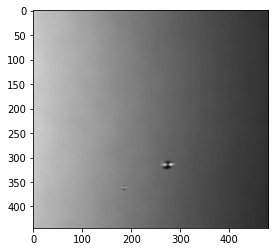

In [116]:
img = im[300:,:] #remove all the surface and the area where the fingers form 
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

We proceed to make a threshold to remove the background. We see because of the ilumination, we need to use adaptative treshold

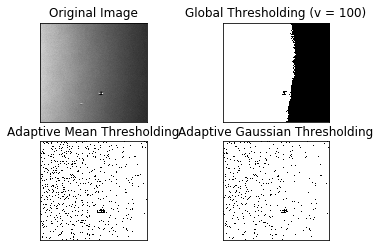

In [117]:
img_blur = cv2.medianBlur(img,3)
ret,th1 = cv2.threshold(img_blur,100,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 100)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

We will use the Gaussian theshold as it seems to give better results.

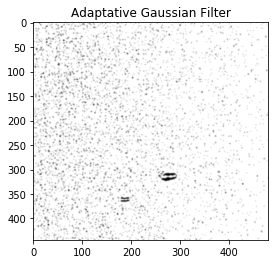

In [118]:
plt.imshow(th3,cmap = 'gray', interpolation = 'bicubic')
plt.title('Adaptative Gaussian Filter')
plt.show()

We makwe a function to perform the adaptative theshold in each image.

In [119]:
def thresholded_image(img,thres=255):
    img_blur = cv2.medianBlur(img,3)
    th3 = cv2.adaptiveThreshold(img_blur,thres,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    return th3

We make a loop through the images to threshold them. We use opencv to find contours in these images. We threshold the contours by area and radius. We draw ellipses around the contours that pass the threshold.
We count the number of contours and we keep the areas as an approximation to the volume.

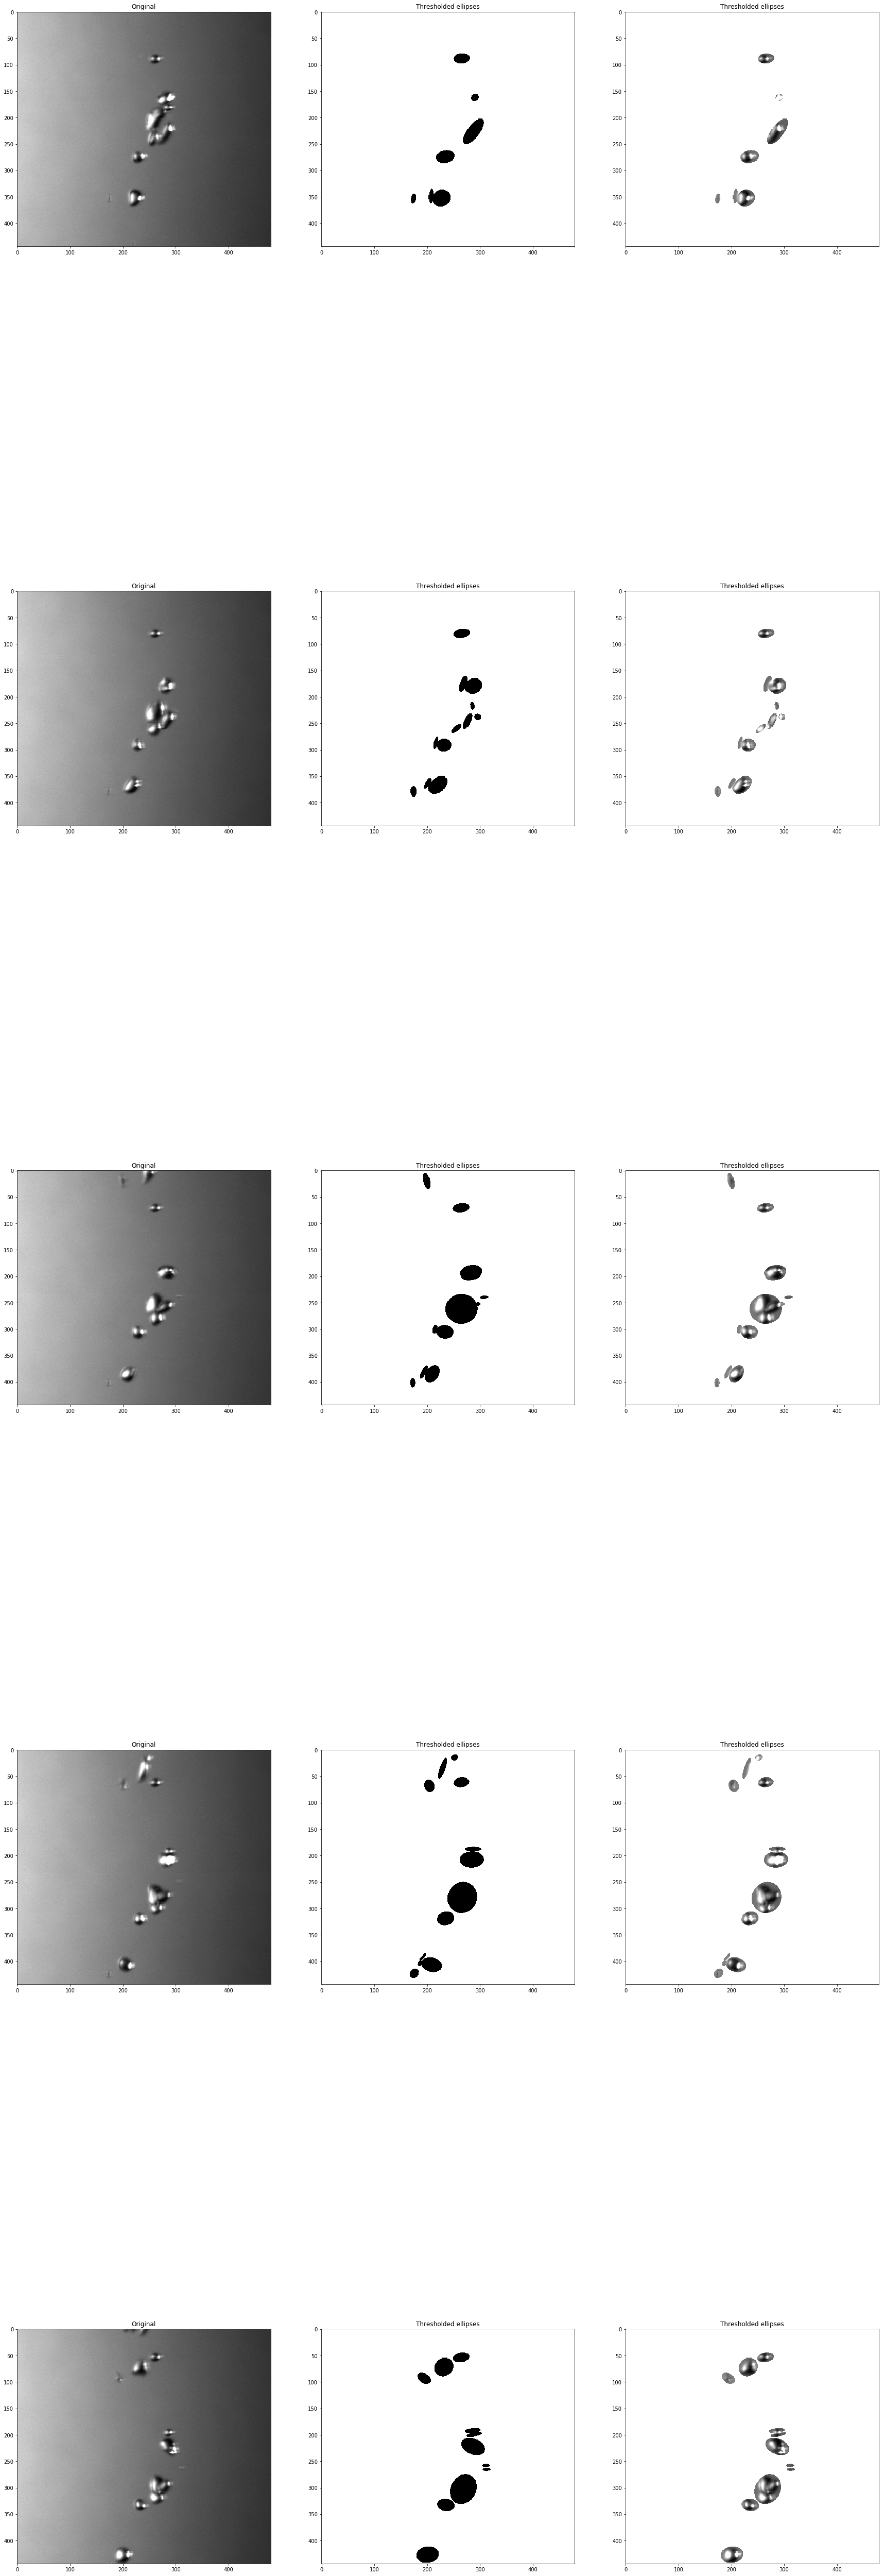

In [129]:
i = 0 #counter for plots and filling arrays
start = 25 #starting image
end = 30 #last image
no_images = end-start #number of images to analize

bubbles = np.zeros(no_images)  #empty array to keep number of bubbles per image
areas = []  #empty list to keep areas, as we need to save each area separated for the histogram
            # and we do not know the amount of bubbles we will get in each image, we cannot prealocate 
            # space for this array 


fig = plt.figure(figsize=(30,100))

#Loop through the images
for arc in filesAOS[start:end]:
    
    img = tiff.imread(arc)[300:,:] #crop the images to the desired size
    edges1 = thresholded_image(img,250)
    #img_blur1 = cv2.medianBlur(edges1,3)
    
    #find contours
    image1, contours1, hierarchy1 = cv2.findContours(edges1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #white image to place the ellipses
    img1 = np.zeros_like(img_blur)
    img1.fill(255)
    
    count = 0 #bubble counter, we reset after each image
    #Loop through the found contours
    for j in range(len(contours1)):
        area = cv2.contourArea(contours1[j]) #find area
        #Thresholds for area in pixels: as we expect "fat" contours we want areas bigger 
        # than 6px*6px=36 we also expect them at most to be 60px*60px = 3600 (as a very rough estimation)
        if 36 < area < 3600:
            ellipse = cv2.fitEllipse(contours1[j]) #fit an ellipse contents are:((Xc,Yc),(2*a,2*b),rotation)
            #Thresholds for the axis of the ellipse: as we said before we d not want any thing which
            # diameter is bigger than 60px so both axis should be smaller than 60
            if ellipse[1][0] < 60 and ellipse[1][1] < 60:
                count+=1 #count a bubble
                img1 = cv2.ellipse(img1,ellipse,(0,255,0),-1) #paint the ellipse in the white image
                areas.append(area)
    bubbles[i] = count #save the amount of bubbles in this image
    
    ax = fig.add_subplot(no_images,3,3*i+1), plt.imshow(img,'gray') #plot original image
    plt.title('Original')
    ax = fig.add_subplot(no_images,3,3*i+2), plt.imshow(img1,'gray') #plot found ellipses
    plt.title('Thresholded ellipses')
    ax = fig.add_subplot(no_images,3,3*i+3), plt.imshow(cv2.add(img,img1),'gray') #plot masked images
    plt.title('Thresholded ellipses')
    i +=1
plt.show()

In [122]:
bubbles

array([10., 13., 17., 18., 18.])

We see that from the illumination we get 2 ellipses for each bubble in some cases. Or one ellipse for several bubbles. Counting by hand in the images above I found that the quantity of bubbles should be:

```python
bubbles_hand = ([9.,8.,11.,13.,10.])
```

Then counting the ellipses by hand I found that the count of visible ellipses is:

```python
ellipses_hand = ([7.,12.,11.,12.,11.])
```

This means that the content of the vector bubbles is not quite what we want to find. So we will better repeat the procedure for the new image that contains the ellipses and in that image count the ellipses and its areas.

In [140]:
i = 0 #counter for plots and filling arrays
start = 25 #staring image
end = 30 #last image
no_images = end-start #number of images to analize

bubbles = np.zeros(no_images)  #empty array to keep number of bubbles per image
areas = []  #empty list to keep areas, as we need to save each area separated for the histogram
            # and we do not know the amount of bubbles we will get in each image, we cannot prealocate 
            # space for this array 


fig = plt.figure(figsize=(30,100))

#Loop through the images
for arc in filesAOS[start:end]:
    
    img = tiff.imread(arc)[300:,:] #crop the images to the desired size
    edges1 = thresholded_image(img,250)
    #img_blur1 = cv2.medianBlur(edges1,3)
    
    #find contours
    image1, contours1, hierarchy1 = cv2.findContours(edges1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #white image to place the ellipses
    img1 = np.zeros_like(img_blur)
    img1.fill(255)
    
    #Loop through the found contours
    for j in range(len(contours1)):
        area = cv2.contourArea(contours1[j]) #find area
        #Thresholds for area in pixels: as we expect "fat" contours we want areas bigger 
        # than 6px*6px=36 we also expect them at most to be 60px*60px = 3600 (as a very rough estimation)
        if 36 < area < 3600:
            ellipse = cv2.fitEllipse(contours1[j]) #fit an ellipse contents are:((Xc,Yc),(2*a,2*b),rotation)
            #Thresholds for the axis of the ellipse: as we said before we d not want any thing which
            # diameter is bigger than 60px so both axis should be smaller than 60
            if ellipse[1][0] < 60 and ellipse[1][1] < 60:
                img1 = cv2.ellipse(img1,ellipse,(0,255,0),-1) #paint the ellipse in the white image
                
    #Now img1 contains the pseudo bubbles that we want to count, so we repeat the procedure and obtain
    # the desired quantities
    image1, contours1, hierarchy1 = cv2.findContours(img1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    #Loop through the found contours we hope the contours we find are only the ones we want
    for j in range(len(contours1)):
        area = cv2.contourArea(contours1[j]) #find area
        areas.append(area)
    bubbles[i] = len(contours1) #save the amount of bubbles in this image
    i+=1
plt.show()

<Figure size 2160x7200 with 0 Axes>

In [141]:
bubbles

array([ 7., 10.,  9., 10., 11.])

Which is much similar to the bubble count, but more important: the total area covered by the ellipses is similar to the area covered by the real bubbles.